# Symbolic Knowledge Extraction
## Getting logic rules that explain the model's behavior

Importing the necessary libraries...

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import _tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
import os
import random
from data import PATH as DATA_PATH

Some global variables that will be used in the code.

In [18]:
TRAINING_DATASET = "adult.data"
TESTING_DATASET = "adult.test"
map_feature_to_label = {
    0: "age",
    1: "workclass",
    2: "fnlwgt",
    3: "education",
    4: "education-num",
    5: "marital-status",
    6: "occupation",
    7: "relationship",
    8: "race",
    9: "capital-gain",
    10: "capital-loss",
    11: "hours-per-week",
    12: "native-country",
    13: "income"
}
map_class_to_label = {
    0: "<=50K",
    1: ">50K"
}
features_to_remove = ["fnlwgt", "education-num"]
map_feature_to_label_reduced = {k: v for k, v in map_feature_to_label.items() if v not in features_to_remove}
FEATURE_NUMBER = 11
CLASS_NUMBER = 2
HIDDEN_SIZE = 64
EPOCHES = 200
BATCH_SIZE = 32
PYTORCH_SEED = 0
NUMPY_SEED = 0
RANDOM_SEED = 0
PRESENTATION = True


### Reproducibility
Set the random seeds for reproducibility.

In [19]:
torch.manual_seed(PYTORCH_SEED)
random.seed(RANDOM_SEED)
np.random.seed(NUMPY_SEED)

### Device selection

In [20]:
if platform.processor() == 'arm' or 'Apple' in platform.platform():
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
if PRESENTATION:
    device = "cpu"
    
print(f"Using device: {device}")

Using device: cpu


### Dataset


In [21]:
if not os.path.exists(os.path.join(DATA_PATH, TRAINING_DATASET)):
    print("Downloading training dataset...")
    os.system(f"wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -P {DATA_PATH}")
if not os.path.exists(os.path.join(DATA_PATH, TESTING_DATASET)):
    print("Downloading testing dataset...")
    os.system(f"wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -P {DATA_PATH}")

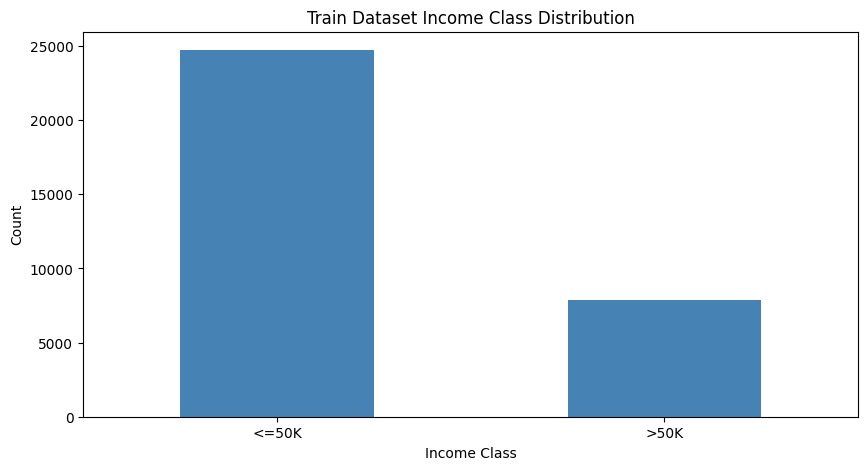

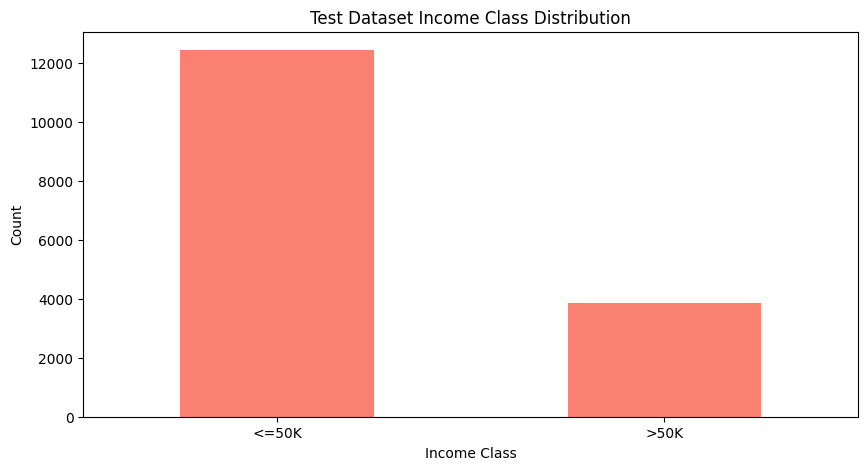

In [22]:
columns = list(map_feature_to_label.values())
df_train = pd.read_csv(DATA_PATH / TRAINING_DATASET, names=columns, na_values=" ?", skipinitialspace=True)
df_test = pd.read_csv(DATA_PATH / TESTING_DATASET, names=columns, na_values=" ?", skipinitialspace=True, skiprows=1)

def preprocess_data(df, kind='Train'):
    df.dropna(inplace=True)
    # Remove features that are not needed for the model
    for feature in features_to_remove:
        if feature in df.columns:
            df.drop(feature, axis=1, inplace=True)
    
    # Encode categorical variables
    categorical_cols = df.select_dtypes(include='object').columns
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    x = df_train.drop("income", axis=1).values
    y = df_train["income"].values
    
    color = 'steelblue' if kind == 'Train' else 'salmon'
    
    plt.figure(figsize=(10, 5))
    df['income'].value_counts().plot(kind='bar', color=color)
    plt.title(f"{kind} Dataset Income Class Distribution")
    plt.xlabel("Income Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0, 1], labels=list(map_class_to_label.values()), rotation=0)
    plt.xticks(rotation=0)
    plt.show()
    
    return x, y

X_train, y_train = preprocess_data(df_train)
X_test, y_test = preprocess_data(df_test, kind='Test')

# Separate features and labels
X_original_train, y_original_train = X_train.copy(), X_train.copy()
X_original_test, y_original_test = X_test.copy(), y_test.copy()

# Normalize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Neural Network Model

In [23]:
class AdultNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(FEATURE_NUMBER, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.ReLU(),
            nn.Linear(HIDDEN_SIZE, CLASS_NUMBER)
        )

    def forward(self, x):
        return self.model(x)

### Training

In [24]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

def train_model() -> tuple[nn.Module, list[float]]:
    model = AdultNet()
    model.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    for epoch in range(EPOCHES):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        if (epoch + 1) % 10 == 0 or epoch == EPOCHES - 1:
            print(f"Epoch {epoch+1}: loss = {loss.item():.4f}")
    
    return model, train_losses

model, train_losses = train_model()

Epoch 10: loss = 0.5925
Epoch 20: loss = 0.5118
Epoch 30: loss = 0.4633
Epoch 40: loss = 0.4364
Epoch 50: loss = 0.4237
Epoch 60: loss = 0.4139
Epoch 70: loss = 0.4052
Epoch 80: loss = 0.3965
Epoch 90: loss = 0.3876
Epoch 100: loss = 0.3789
Epoch 110: loss = 0.3708
Epoch 120: loss = 0.3637
Epoch 130: loss = 0.3581
Epoch 140: loss = 0.3536
Epoch 150: loss = 0.3500
Epoch 160: loss = 0.3469
Epoch 170: loss = 0.3444
Epoch 180: loss = 0.3420
Epoch 190: loss = 0.3400
Epoch 200: loss = 0.3380


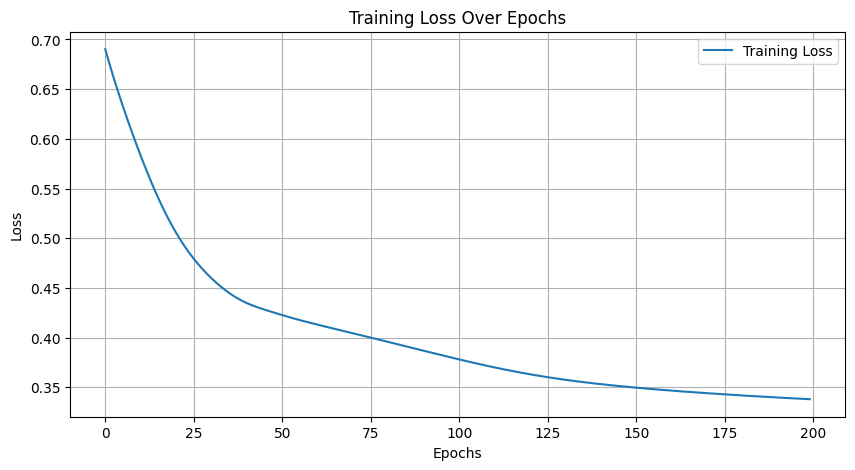

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluation

In [26]:
def evaluate(model):
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)
    model.eval()
    with torch.no_grad():
        output = model(X_test_tensor)
        _, predicted = torch.max(output, 1)
        report = classification_report(y_test_tensor.cpu(), predicted.cpu(), target_names=list(map_class_to_label.values()), output_dict=True)
    return report

report = evaluate(model)

print("--- Classification Report with Symbolic Knowledge ---")
print(pd.DataFrame(report).transpose())

--- Classification Report with Symbolic Knowledge ---
              precision    recall  f1-score       support
<=50K          0.867812  0.935882  0.900562  24720.000000
>50K           0.731447  0.550568  0.628247   7841.000000
accuracy       0.843094  0.843094  0.843094      0.843094
macro avg      0.799629  0.743225  0.764405  32561.000000
weighted avg   0.834974  0.843094  0.834986  32561.000000


### Train a Symbolic Approximator (Decision Tree) 

In [27]:
y_train_pred = torch.argmax(model(X_train_tensor), dim=1).cpu().numpy()
dt = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=7, random_state=RANDOM_SEED)
dt.fit(X_original_train, y_train_pred)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,7
,min_impurity_decrease,0.0
,class_weight,None


### Extract Logical Rules from the Tree

In [28]:
rules = export_text(dt, feature_names=list(map_feature_to_label_reduced.values())[:-1])
print("Extracted Symbolic Rules:\n")
print(rules)

Extracted Symbolic Rules:

|--- education <= 12.50
|   |--- capital-gain <= 3048.00
|   |   |--- class: 0
|   |--- capital-gain >  3048.00
|   |   |--- class: 1
|--- education >  12.50
|   |--- occupation <= 0.50
|   |   |--- hours-per-week <= 31.00
|   |   |   |--- class: 0
|   |   |--- hours-per-week >  31.00
|   |   |   |--- class: 1
|   |--- occupation >  0.50
|   |   |--- capital-gain <= 3869.00
|   |   |   |--- occupation <= 4.50
|   |   |   |   |--- class: 0
|   |   |   |--- occupation >  4.50
|   |   |   |   |--- class: 1
|   |   |--- capital-gain >  3869.00
|   |   |   |--- class: 1



In [29]:
def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature]

    rules = []

    def recurse(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], conditions + [f"{name} <= {threshold:.3f}"])
            recurse(tree_.children_right[node], conditions + [f"{name} > {threshold:.3f}"])
        else:
            value = np.argmax(tree_.value[node])
            rule = f"class = {value} if " + " and ".join(conditions)
            rules.append(rule)

    recurse(0, [])
    return rules

In [30]:
print("Extracted Symbolic Rules (One per Line):\n")
rules = tree_to_rules(dt, list(map_feature_to_label_reduced.values())[:-1])
for rule in rules:
    print(rule)

Extracted Symbolic Rules (One per Line):

class = 0 if education <= 12.500 and capital-gain <= 3048.000
class = 1 if education <= 12.500 and capital-gain > 3048.000
class = 0 if education > 12.500 and occupation <= 0.500 and hours-per-week <= 31.000
class = 1 if education > 12.500 and occupation <= 0.500 and hours-per-week > 31.000
class = 0 if education > 12.500 and occupation > 0.500 and capital-gain <= 3869.000 and occupation <= 4.500
class = 1 if education > 12.500 and occupation > 0.500 and capital-gain <= 3869.000 and occupation > 4.500
class = 1 if education > 12.500 and occupation > 0.500 and capital-gain > 3869.000


### Visual representation of the rules

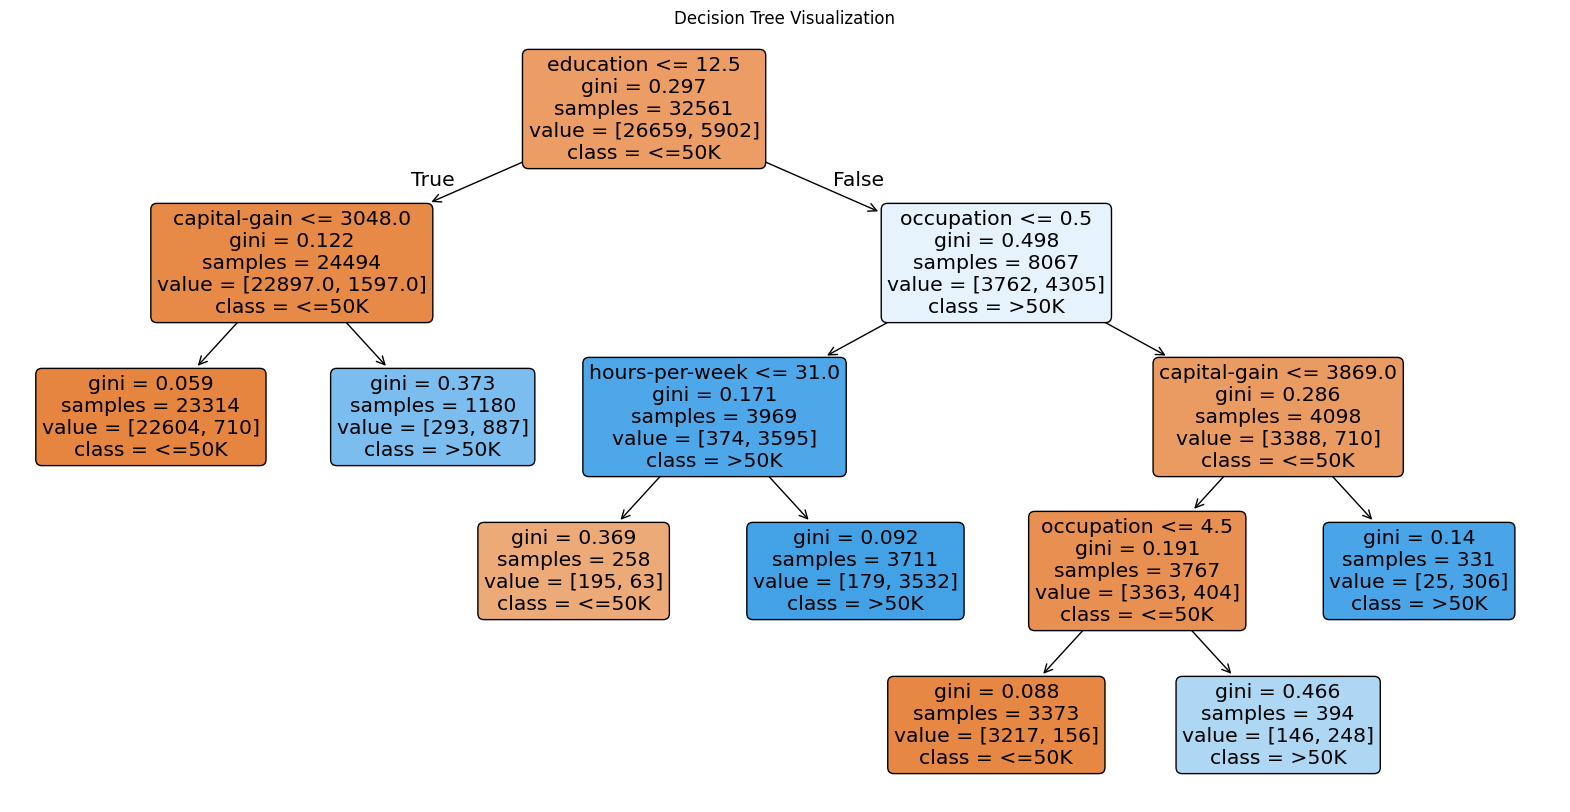

In [31]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=list(map_feature_to_label_reduced.values())[:-1], class_names=list(map_class_to_label.values()), filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

### Evaluate Decision Tree Approximator (Fidelity)

In [32]:
y_dt_pred = dt.predict(X_original_test)
y_pred = torch.argmax(model(torch.tensor(X_test, dtype=torch.float32).to(device)), dim=1).cpu().numpy()
print("Decision Tree Approximation Report:\n")
print(classification_report(y_pred, y_dt_pred))

Decision Tree Approximation Report:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     26659
           1       0.89      0.84      0.86      5902

    accuracy                           0.95     32561
   macro avg       0.93      0.91      0.92     32561
weighted avg       0.95      0.95      0.95     32561

